In [146]:
import sys
import os

current_dir = os.getcwd()  # dir corrente
root_path = os.path.abspath(os.path.join(current_dir, '..')) # path per dir principale
sys.path.append(root_path)

from imports import *


In [147]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [148]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_complete.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_complete.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")

In [149]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [150]:
column_to_number = {
    'SV1': 1,
    'SV2': 2,
    'SV3': 3,
    'SV4': 4,
}

df_labels['fault_sv'] = 0
df_labels['opening_ratio'] = 100


for index, row in df_labels.iterrows():
    for col in column_to_number.keys():
        if row[col] < 100:
            val=row[col]
            df_labels.at[index, 'fault_sv'] = column_to_number[col]
            df_labels.at[index,'opening_ratio'] = [val]
            break



In [151]:
df_labels["fault_sv"].tail(50)

127    2
128    2
129    3
130    3
131    3
132    3
133    4
134    4
135    4
136    4
137    1
138    1
139    1
140    1
141    2
142    2
143    2
144    2
145    3
146    3
147    3
148    3
149    4
150    4
151    4
152    4
153    0
154    0
155    0
156    0
157    0
158    0
159    0
160    0
161    0
162    0
163    0
164    0
165    0
166    0
167    0
168    0
169    0
170    0
171    0
172    0
173    0
174    0
175    0
176    0
Name: fault_sv, dtype: int64

In [152]:
df_normal = df_train[:106]
df_fault=df_train[105:153]

df_labels=df_labels[105:153]
df_train=df_train[105:153]

In [153]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
105,105,0.052357,0.654635,0.351878,0.315838,0.647224,0.439810,0.668211,0.785405,0.449112,...,0.317209,0.578535,0.563078,0.249533,0.509906,1.0,0.249533,0.545152,0.657535,0.522463
106,106,0.867260,0.855489,0.917812,0.266160,0.681149,0.356433,0.927012,0.487642,0.402322,...,0.548534,0.668887,0.671507,0.467184,0.621233,0.8,0.467184,0.734110,0.585896,0.321131
107,107,0.861705,0.875727,0.897897,0.283671,0.653145,0.434774,0.902716,0.468960,0.388470,...,0.498982,0.548327,0.550601,0.417742,0.491155,0.8,0.417742,0.643648,0.492519,0.447587
108,108,0.859533,0.847921,0.886049,0.294589,0.635187,0.412508,0.899782,0.456635,0.379678,...,0.533284,0.595139,0.597513,0.451797,0.541409,0.8,0.451797,0.690104,0.517903,0.041597
109,109,0.097322,0.665730,0.233585,0.345146,0.618351,0.705987,0.174339,0.868056,0.412636,...,0.285040,0.561699,0.545182,0.221797,0.492568,0.8,0.221797,0.490784,0.664656,0.049917
110,110,0.861230,0.947341,0.872779,0.285523,0.660740,0.358421,0.860933,0.485819,0.393010,...,0.515639,0.646134,0.647799,0.434183,0.594941,0.8,0.434183,0.685885,0.585853,0.740433
111,111,0.851430,0.954126,0.879892,0.291472,0.647887,0.354309,0.873410,0.468076,0.389228,...,0.502679,0.621939,0.623321,0.421375,0.567667,0.8,0.421375,0.670359,0.568315,0.231281
112,112,0.848011,0.957580,0.888437,0.291415,0.648048,0.372016,0.872421,0.462917,0.391166,...,0.650151,0.692083,0.698937,0.573742,0.654291,0.8,0.573742,0.843473,0.537719,0.562396
113,113,0.105846,0.565080,0.248407,0.388752,0.601374,0.795180,0.282319,0.753161,0.430740,...,0.354188,0.625479,0.616626,0.282146,0.573530,1.0,0.282146,0.535575,0.698453,0.688852
114,114,0.833727,0.821017,0.882332,0.284824,0.670706,0.492722,0.715636,0.484853,0.406980,...,0.586591,0.623041,0.628486,0.506262,0.572243,0.8,0.506262,0.755976,0.508105,0.575707


In [154]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0
110,110,111,1,2,100,25,100,100,0,0,0,0,0,0,0,0,1,2,25
111,111,112,1,2,100,50,100,100,0,0,0,0,0,0,0,0,1,2,50
112,112,113,1,2,100,75,100,100,0,0,0,0,0,0,0,0,1,2,75
113,113,114,1,2,100,100,0,100,0,0,0,0,0,0,0,0,1,3,0
114,114,115,1,2,100,100,25,100,0,0,0,0,0,0,0,0,1,3,25


In [155]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [156]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [157]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [158]:
df_train=df_train.drop(columns="index")

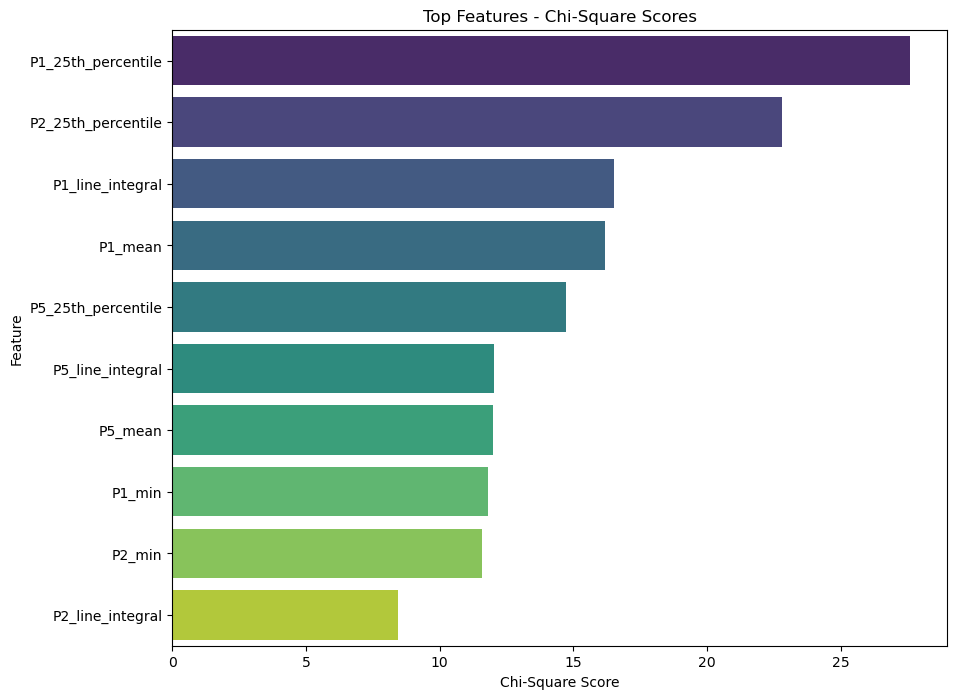

In [159]:
features_chi2 = feature_selection_chi2(df_train,df_labels["opening_ratio"],10)


df_train = df_train[features_chi2]
df_test = df_test[features_chi2]

In [160]:
from scipy.stats import pearsonr

In [161]:
plt.figure(figsize=(14,8))
correlations = []
for column in df_train.columns:
    corr, p_value = pearsonr(df_labels['opening_ratio'], df_train[column])
    correlations.append((column, corr, p_value))

correlation_df = pd.DataFrame(correlations, columns=['Column', 'Correlation', 'P-value'])
sorted_correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)
# print(correlation_df)
print(sorted_correlation_df)

correlation_matrix = df_train.corrwith(df_labels['opening_ratio']).to_frame().T
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()


               Column  Correlation       P-value
8              P2_min    -0.573881  2.004876e-05
9    P2_line_integral    -0.671363  1.761682e-07
7              P1_min    -0.737157  2.304863e-09
4  P5_25th_percentile    -0.758784  4.138854e-10
3             P1_mean    -0.759074  4.039747e-10
2    P1_line_integral    -0.759104  4.029543e-10
1  P2_25th_percentile    -0.763973  2.668840e-10
6             P5_mean    -0.765671  2.306176e-10
5    P5_line_integral    -0.765767  2.287271e-10
0  P1_25th_percentile    -0.773289  1.179680e-10


<Figure size 1400x800 with 0 Axes>

In [162]:
def calculate_average_dtw(anomalous_vector, normal_vectors):
    distances = []
    for normal_vector in normal_vectors:
        distance, _ = fastdtw(anomalous_vector.reshape(-1, 1), normal_vector.reshape(-1, 1), dist=euclidean)
        distances.append(distance)
    return np.mean(distances)

average_distances = []

for i in range(df_fault.shape[0]):
    anomalous_vector = df_fault.iloc[i].values
    normal_vectors = [df_normal.iloc[j].values for j in range(df_normal.shape[0])]
    avg_distance = calculate_average_dtw(anomalous_vector, normal_vectors)
    average_distances.append(avg_distance)

In [163]:
average_distances

[102.86141793317262,
 89.0000141549496,
 84.59829480301613,
 86.50596291013956,
 108.94774968031734,
 91.78069158750714,
 91.18479562719835,
 92.07174403367779,
 113.17619658071816,
 94.99120685338725,
 95.10938004008266,
 94.7486071760754,
 115.98697589100011,
 98.03088044868227,
 98.35234263820189,
 98.97959796820919,
 118.837860794594,
 108.17024888515996,
 98.28571387630505,
 99.8378564741162,
 129.21018936776386,
 110.56901858816389,
 110.02032635571125,
 106.9472513183608,
 133.03899004288138,
 107.7943529062401,
 110.57447178756657,
 111.09660221797753,
 138.67097260113553,
 115.16444340546215,
 115.81085268282963,
 113.72773718140853,
 139.1228156094299,
 128.5675235972811,
 121.0443251843951,
 122.59826783162588,
 138.3492616477028,
 123.34003803494473,
 123.98165843229708,
 123.77917838529295,
 147.9269769093782,
 133.78898368269552,
 128.39531540658874,
 129.07781304118367,
 153.84437005274927,
 136.1699712024985,
 136.0123497609777,
 134.12471136748516]

In [164]:
df_train["dtw"] = average_distances

In [170]:
df_train

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral,dtw
105,0.982800,0.980042,0.947743,0.947643,0.742798,0.589270,0.589128,0.563963,0.636005,0.889589,102.861418
106,0.059154,0.066443,0.128738,0.132740,0.181802,0.083007,0.083189,0.000000,0.000403,0.000000,89.000014
107,0.066919,0.070128,0.134247,0.138295,0.164252,0.061677,0.061822,0.079907,0.004243,0.402981,84.598295
108,0.042085,0.056827,0.136400,0.140467,0.176166,0.115446,0.115649,0.127828,0.006799,0.225642,86.505963
109,0.986978,1.000000,0.902477,0.902678,0.744361,0.770074,0.770205,0.818104,0.424390,0.939311,108.947750
110,0.066142,0.060036,0.134753,0.138770,0.163519,0.130730,0.131026,0.181181,0.008433,0.309078,91.780692
111,0.097109,0.063489,0.144547,0.148570,0.178516,0.100581,0.100804,0.173570,0.013025,0.088134,91.184796
112,0.095904,0.058392,0.147966,0.151989,0.174408,0.042970,0.043104,0.163054,0.013710,0.164769,92.071744
113,0.961357,0.732297,0.893879,0.894154,0.970227,0.958038,0.958053,0.876307,0.179641,0.622330,113.176197
114,0.049094,0.047581,0.162335,0.166273,0.167988,0.119647,0.119747,0.179239,0.013892,0.284756,94.991207


In [167]:
# df_train
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0
110,110,111,1,2,100,25,100,100,0,0,0,0,0,0,0,0,1,2,25
111,111,112,1,2,100,50,100,100,0,0,0,0,0,0,0,0,1,2,50
112,112,113,1,2,100,75,100,100,0,0,0,0,0,0,0,0,1,2,75
113,113,114,1,2,100,100,0,100,0,0,0,0,0,0,0,0,1,3,0
114,114,115,1,2,100,100,25,100,0,0,0,0,0,0,0,0,1,3,25


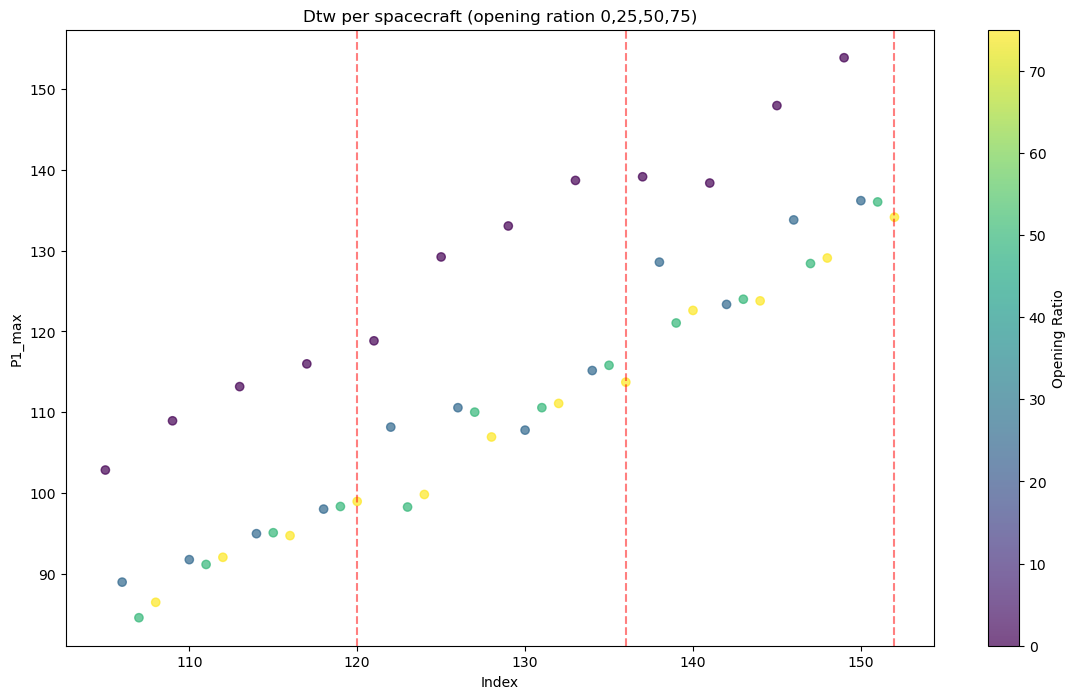

In [172]:
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    df_train.index, 
    df_train["dtw"], 
    c=df_labels["opening_ratio"],  
    cmap='viridis',  
    alpha=0.7 
)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Opening Ratio')

# Add vertical lines for each unique spacecraft
unique_spacecraft = df_labels["Spacecraft"].unique()
for spacecraft in unique_spacecraft:
    indices = df_labels.index[df_labels["Spacecraft"] == spacecraft].tolist()
    last_index = indices[-1]  # Get the last index in the list
    plt.axvline(x=last_index, color='red', linestyle='--', alpha=0.5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('P1_max')
plt.title('Dtw per spacecraft (opening ration 0,25,50,75)')

# Show plot
plt.show()

In [ ]:
df_train.head(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
105,0.982800,0.980042,0.947743,0.947643,0.742798,0.589270,0.589128,0.563963,0.636005,0.889589
106,0.059154,0.066443,0.128738,0.132740,0.181802,0.083007,0.083189,0.000000,0.000403,0.000000
107,0.066919,0.070128,0.134247,0.138295,0.164252,0.061677,0.061822,0.079907,0.004243,0.402981
108,0.042085,0.056827,0.136400,0.140467,0.176166,0.115446,0.115649,0.127828,0.006799,0.225642
109,0.986978,1.000000,0.902477,0.902678,0.744361,0.770074,0.770205,0.818104,0.424390,0.939311


In [ ]:
# df_train["open_ratio"] = df_labels["opening_ratio"]
# df_train = df_train[df_train["open_ratio"] != 0]
# df_labels = df_labels[df_labels["opening_ratio"] != 0]
# df_train =df_train.drop(columns=["open_ratio"])

In [ ]:
df_train

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
105,0.982800,0.980042,0.947743,0.947643,0.742798,0.589270,0.589128,0.563963,0.636005,0.889589
106,0.059154,0.066443,0.128738,0.132740,0.181802,0.083007,0.083189,0.000000,0.000403,0.000000
107,0.066919,0.070128,0.134247,0.138295,0.164252,0.061677,0.061822,0.079907,0.004243,0.402981
108,0.042085,0.056827,0.136400,0.140467,0.176166,0.115446,0.115649,0.127828,0.006799,0.225642
109,0.986978,1.000000,0.902477,0.902678,0.744361,0.770074,0.770205,0.818104,0.424390,0.939311
110,0.066142,0.060036,0.134753,0.138770,0.163519,0.130730,0.131026,0.181181,0.008433,0.309078
111,0.097109,0.063489,0.144547,0.148570,0.178516,0.100581,0.100804,0.173570,0.013025,0.088134
112,0.095904,0.058392,0.147966,0.151989,0.174408,0.042970,0.043104,0.163054,0.013710,0.164769
113,0.961357,0.732297,0.893879,0.894154,0.970227,0.958038,0.958053,0.876307,0.179641,0.622330
114,0.049094,0.047581,0.162335,0.166273,0.167988,0.119647,0.119747,0.179239,0.013892,0.284756


In [ ]:
X = df_train

# n_clusters = 4

# kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(X)

# labels = kmeans.labels_
# centroids = kmeans.cluster_centers_

# df_labels['Cluster'] = labels

# plt.figure(figsize=(10, 8))
# plt.scatter(df_train['P1_line_integral'], df_train['dtw'], c=df_labels['Cluster'], cmap='viridis', label=df_labels["Cluster"].unique())

# plt.xlabel('P1_line_integral')
# plt.ylabel('P2_BandPower')
# plt.title('K-means clustering con 4 cluster')
# plt.legend()
# plt.show()

In [ ]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0
110,110,111,1,2,100,25,100,100,0,0,0,0,0,0,0,0,1,2,25
111,111,112,1,2,100,50,100,100,0,0,0,0,0,0,0,0,1,2,50
112,112,113,1,2,100,75,100,100,0,0,0,0,0,0,0,0,1,2,75
113,113,114,1,2,100,100,0,100,0,0,0,0,0,0,0,0,1,3,0
114,114,115,1,2,100,100,25,100,0,0,0,0,0,0,0,0,1,3,25


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_labels["opening_ratio"], test_size=0.33, random_state=42)


In [ ]:
y_test

132    75
145     0
131    50
148    75
129     0
142    25
117     0
124    75
109     0
130    25
113     0
108    75
111    50
144    75
138    25
118    25
Name: opening_ratio, dtype: int64

In [ ]:
# df_train["sv"] = df_labels["fault_sv"]

In [ ]:

model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

y_pred_linear = model_linear.predict(X_test)

mae_linear = mean_absolute_error(y_test, y_pred_linear)
print("Mean Absolute Error:", mae_linear)

Mean Absolute Error: 18.88085794529916


In [ ]:
print("y_pred: ", y_pred_linear)
print(" ----------------------------------------------------------------- ")
print("y_test : ", y_test.values)

y_pred:  [ 60.83357369   0.75011531  52.26182063  58.80237202   9.36844626
  63.43013389  -3.12568734  55.6041524    9.77588123  30.25210094
 -29.34059039  41.2636179   57.64913054  42.09137655  74.22567841
  55.50923475]
 ----------------------------------------------------------------- 
y_test :  [75  0 50 75  0 25  0 75  0 25  0 75 50 75 25 25]


In [ ]:
df_test

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
0,0.188521,0.039488,0.079321,0.082119,0.251141,0.055201,0.054306,0.371555,0.892153,0.218569
1,0.063933,0.046077,0.143726,0.147686,0.174802,0.130994,0.131273,0.182168,0.007976,0.351138
2,0.065567,0.056646,0.148848,0.152884,0.176327,0.069548,0.069689,0.152192,0.014128,0.176715
3,0.061874,0.042924,0.152639,0.156664,0.169909,0.186084,0.186267,0.162786,0.014086,0.178976
4,0.065674,0.056385,0.146502,0.150548,0.179430,0.071468,0.071635,0.152803,0.014132,0.182215
5,0.064793,0.058526,0.138308,0.142371,0.176327,0.077004,0.077192,0.152057,0.014342,0.178901
6,25.221792,17.693374,128.022406,127.576711,15.878233,86.454785,86.581226,1.861598,1.726244,67.370615
7,0.068747,0.059840,0.137160,0.141229,0.179970,0.102089,0.102284,0.152060,0.014342,0.175463
8,0.032575,0.162470,0.052874,0.052536,0.200950,0.156484,0.150024,0.307737,0.036904,0.213790
9,0.065113,0.053632,0.141022,0.145077,0.179866,0.134594,0.134792,0.152046,0.014222,0.181163


In [ ]:
pred=model_linear.predict(df_test)

In [ ]:
pred=pred.astype(str)

In [ ]:
pred

array(['-97.5632293356833', '38.67716188046583', '57.07277542060231',
       '37.89979439887074', '55.860690951920816', '53.78246094254439',
       '-4852.48500485332', '49.66191577192291', '-132.85360642131718',
       '43.4152535414066', '0.6233796972359755', '44.43207663122135',
       '33.152842727010125', '47.64234148675766', '-4727.709903681753',
       '-134.76804960582902', '52.92174911144764', '55.686650182893175',
       '-51.760749930463646', '-120.19218741078745', '49.63314061500674',
       '54.95710078044041', '-4852.48500485332', '47.610013035785045',
       '50.9993561410345', '51.26879213077842', '37.03176295741994',
       '50.380887382507666', '56.609539132275046', '-4732.42310292615',
       '49.125434442476575', '-82.29634352036739', '53.959631045983514',
       '46.5282058461986', '65.05642525043098', '53.99343683175519',
       '53.7652533223324', '49.19832602906354', '-140.841049693084',
       '50.548563848276075', '-4860.52443969611', '80.52001031119102',
    

In [ ]:
print("Rapporto di apertura per casi di test")


pd.Series(pred[[0,2,3,4,8,7]]).values.tolist()

Rapporto di apertura per casi di test


['-97.5632293356833',
 '57.07277542060231',
 '37.89979439887074',
 '55.860690951920816',
 '-132.85360642131718',
 '49.66191577192291']